In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import InputLayer, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/N_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Barents = pd.read_excel(filepath, sheet_name='Barents-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/NH/')
import Function as fp

In [4]:
fp.month_mapping(Barents)
fp.date_time(Barents)

Extent       Date
0    1107873.946 1979-01-01
1    1211101.473 1979-02-01
2    1215128.770 1979-03-01
3    1233940.811 1979-04-01
4    1193061.566 1979-05-01
..           ...        ...
533   124025.343 2023-06-01
534    53107.426 2023-07-01
535    11242.827 2023-08-01
536     3272.024 2023-09-01
537    35079.225 2023-10-01

[538 rows x 2 columns]

In [5]:
scaler = MinMaxScaler()
Barents['Extent'] = scaler.fit_transform(Barents['Extent'].values.reshape(-1, 1))

In [6]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    lead_time = 2
    for i in range(len(df_as_np) - window_size - lead_time + 1):
        window_data = df_as_np[i:i+window_size]
        row = [[a] for a in window_data]
        X.append(row)
        label = df_as_np[i+window_size+lead_time-1]
        y.append(label)
    return np.array(X), np.array(y)

In [7]:
extent = Barents['Extent']
W_S=12
X,y = df_to_X_y(extent, W_S)
X.shape, y.shape

((525, 12, 1), (525,))

In [8]:
X_train, y_train = X[:420], y[:420]
X_val, y_val = X[420:472], y[420:472]
X_test, y_test = X[472:], y[472:]

In [9]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0)))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Barents_model_LT2/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [10]:
import time

stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
53/53 [==============================] - 23s 287ms/step - loss: 0.1836 - root_mean_squared_error: 0.4285 - val_loss: 0.0494 - val_root_mean_squared_error: 0.2223
Epoch 2/50
53/53 [==============================] - 14s 261ms/step - loss: 0.0861 - root_mean_squared_error: 0.2935 - val_loss: 0.0436 - val_root_mean_squared_error: 0.2087
Epoch 3/50
53/53 [==============================] - 13s 240ms/step - loss: 0.0496 - root_mean_squared_error: 0.2227 - val_loss: 0.0339 - val_root_mean_squared_error: 0.1842
Epoch 4/50
53/53 [==============================] - 12s 227ms/step - loss: 0.0392 - root_mean_squared_error: 0.1980 - val_loss: 0.0302 - val_root_mean_squared_error: 0.1737
Epoch 5/50
53/53 [==============================] - 12s 222ms/step - loss: 0.0309 - root_mean_squared_error: 0.1758 - val_loss: 0.0206 - val_root_mean_squared_error: 0.1435
Epoch 6/50
53/53 [==============================] - 12s 237ms/step - loss: 0.0255 - root_mean_squared_error: 0.1597 - val_loss: 0.0187 

Epoch 37/50
53/53 [==============================] - 2s 34ms/step - loss: 0.0135 - root_mean_squared_error: 0.1163 - val_loss: 0.0119 - val_root_mean_squared_error: 0.1089
Epoch 38/50
53/53 [==============================] - 2s 34ms/step - loss: 0.0136 - root_mean_squared_error: 0.1166 - val_loss: 0.0120 - val_root_mean_squared_error: 0.1095
Epoch 39/50
53/53 [==============================] - 2s 37ms/step - loss: 0.0138 - root_mean_squared_error: 0.1175 - val_loss: 0.0123 - val_root_mean_squared_error: 0.1108
Epoch 40/50
53/53 [==============================] - 2s 31ms/step - loss: 0.0128 - root_mean_squared_error: 0.1131 - val_loss: 0.0145 - val_root_mean_squared_error: 0.1203
Epoch 41/50
53/53 [==============================] - 2s 31ms/step - loss: 0.0129 - root_mean_squared_error: 0.1136 - val_loss: 0.0114 - val_root_mean_squared_error: 0.1068
Epoch 42/50
53/53 [==============================] - 2s 31ms/step - loss: 0.0142 - root_mean_squared_error: 0.1193 - val_loss: 0.0132 - val_

In [11]:
time = (etime - stime)/60
print(f'{time} minutes')

4.029716328779856 minutes


In [12]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

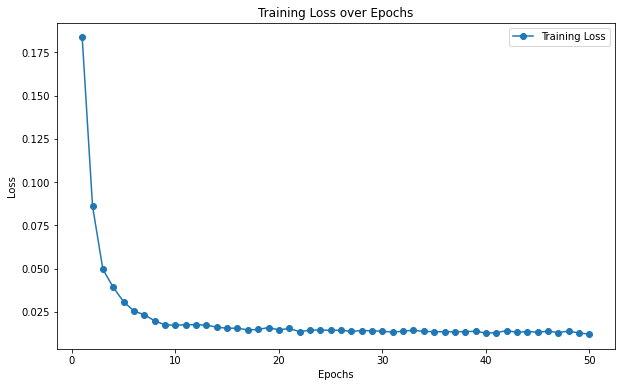

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

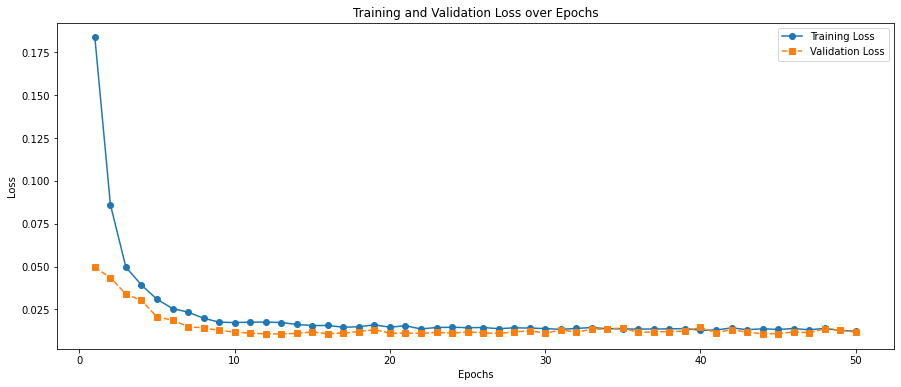

In [14]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [15]:
from tensorflow.keras.models import load_model
model1 = load_model('Barents_model_LT2/')

In [16]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 1s 16ms/step


In [17]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.0930532848799967
MAE : 0.07482227367133287


In [18]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

In [19]:
train_results = pd.DataFrame(data={'Train Predictions': test_predictions.flatten(), 'Actual Extent': test_original.flatten()})
train_results

Train Predictions  Actual Extent
0       201184.968750     265975.112
1        45047.718750     112300.019
2        34361.207031      44787.893
3        59100.914062      14909.156
4       103782.367188      54595.378
5       172513.062500     242829.930
6       268236.031250     406860.687
7       386832.843750     605897.837
8       515216.406250     654073.790
9       579529.500000     701143.910
10      561693.062500     657891.340
11      401796.531250     432215.421
12      213572.500000     201834.787
13       86773.164062      55041.511
14       65420.488281       5387.468
15       99648.867188       1576.813
16      164263.156250      21681.895
17      260594.093750      37772.681
18      388804.968750     239568.531
19      508731.500000     427703.330
20      597827.437500     753043.012
21      621130.937500     764554.603
22      583105.437500     563799.961
23      433977.625000     444109.886
24      188625.968750     189669.492
25       59267.019531      63664.521
26       43644.300781       5984.539
27       72704.070312       1192.062
28      125801.679688      25987.740
29      203972.375000     227374.130
30      309495.500000     498316.637
31      450031.375000     666292.874
32      574365.937500     673348.837
33      645596.812500     635756.948
34      568621.937500     673503.693
35      379041.031250     550922.786
36      181265.437500     116554.569
37       63801.179688      12012.356
38       62874.898438       5446.433
39      103349.406250       2183.701
40      172846.218750      31883.576
41      272993.531250      98802.296
42      408882.687500     224779.107
43      540318.812500     287476.263
44      607992.000000     376683.928
45      614703.437500     571055.966
46      582545.250000     581039.946
47      491169.156250     376525.530
48      255858.546875     124025.343
49       25989.822266      53107.426
50       25842.468750      11242.827
51       46566.472656       3272.024
52       83740.945312      35079.225

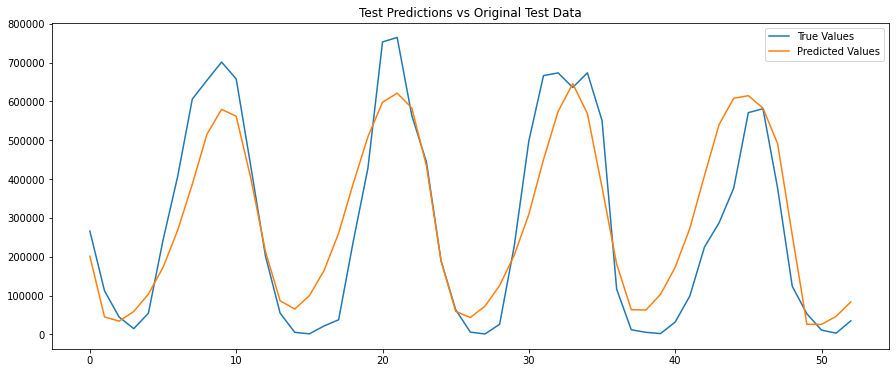

In [20]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [21]:
predictions = model1.predict(X)

17/17 [==============================] - 0s 14ms/step


In [22]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

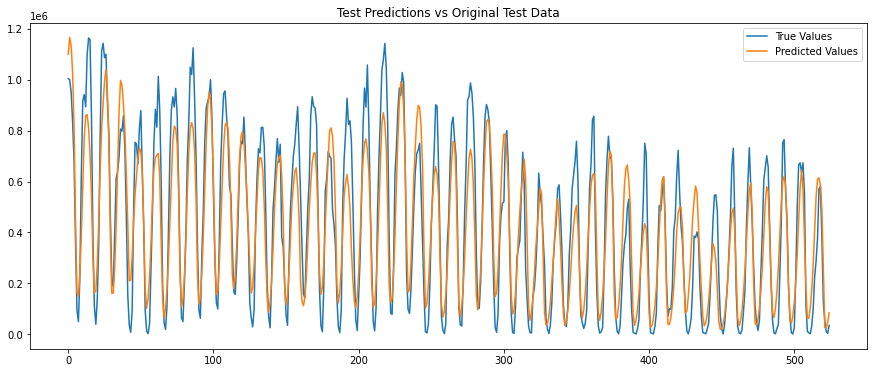

In [23]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()